# Grover's algorithm

## Overview

- **Time complexity:** $O(\sqrt{N})$, where $N$ is the size of the search space
- **Speedup:** Quadratic
- **Approachability:** Medium
- **Related topics:** Amplitude amplification

Grover's algorithm is a search algorithm that has a provable quadratic speedup for unstructured problems.

As it ignores any problem structure, Grover's algorithm is widely applicable but often less efficient than problem-specific algorithms. While unlikely to be useful by itself, Grover's algorithm was an important development in quantum computing. Its ideas were later generalized into _amplitude amplification_, which appears in more sophisticated quantum algorithms.

This page should be understandable to anyone comfortable with basic quantum computing concepts.

## Problem form

Grover's algorithm is a black-box algorithm. Its input is a quantum circuit called the _oracle_. The oracle multiplies the amplitudes of some states by -1 (we'll call such states "good" states), and leaves all other amplitudes unchanged. Given an oracle, the goal is to find one of these good states.

$$
U_\text{oracle}|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \notin \text{good strings} \\
-|x\rangle \quad \text{if} \; x \in \text{good strings} \\
\end{aligned}
$$

The following code example creates a matrix for an example oracle. For now, we'll use a priori knowledge of the good strings, but the next section will show how to transform problems to oracle circuits _without_ knowing their good strings beforehand.

In [6]:
NUM_QUBITS = 3
good_states = ["011", "110"]

# Create an identity matrix
from numpy import identity

oracle = identity(2**NUM_QUBITS, dtype=int)

# Alter matrix to mark "good" states
for state in good_states:
    INDEX = int(state, 2)  # Convert bit string to int
    oracle[INDEX][INDEX] = -1

print(f"Oracle matrix:\n{oracle}")

Oracle matrix:
[[ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  1]]


### Converting problems to oracles

#### Computational search

The most likely use case for Grover's algorithm is _computational search_, in which the oracle is a circuit that computes whether bit strings are "good" or not. This section shows a simple technique to transform many classical problems to oracle circuits that Grover's algorithm could solve.

The problem must have a function for evaluating whether a bit string is "good" or not. For example, if we have a function that verifies solutions to a sudoku, we could use Grover's algorithm to solve that sudoku. The function should have the following form.

$$
f(x) = \bigg\{
\begin{aligned}
0 \quad \text{if} \; x \notin \text{good states} \\
1 \quad \text{if} \; x \in \text{good states} \\
\end{aligned}
$$


To convert this function to an oracle, first implement the classical function $f(x)$, as a reversible circuit
   
![A Classical reversible oracle](images/grover/boolean-oracle.svg)

Next, initialize the 'output' qubit to the state $|{-}\rangle$. Phase kickback effect turns this into a Grover oracle (similar to the workings of the Deutsch-Jozsa oracle).
   
![Grover oracle constructed from a classical reversible oracle](images/grover/phase-oracle.svg)

$$
U_\text{f}|x\rangle|{-}\rangle = \bigg\{
\begin{aligned}
&|x\rangle|{-}\rangle \quad &\text{if} \; x \notin \text{good states} \\
&|x\rangle\otimes X |{-}\rangle = -|x\rangle|{-}\rangle \quad &\text{if} \; x \in \text{good states} \\
\end{aligned}
$$

We can then ignore the auxiliary ($|{-}\rangle$) qubit.


#### Database search

In theory, Grover's algorithm could also search databases of recorded information. A popular example of unstructured search is searching a phone book by telephone number, rather than by name. Since phone books are not ordered by number, we have no information about where in the book the number will be, that is, the problem has no _structure_. The best classical algorithm for unstructured search is _random guessing_, in which we select random entries and check if they contain the correct phone number. This will take $N/2$ database queries on average, whereas Grover's algorithm would take ~$\sqrt{N}$.

In reality, Grover's algorithm is unlikely to ever be used for database search. Today's classical computers are fast, so the database searches would need to be very large for Grover's algorithm to show an advantage. These large databases would need to be stored on special quantum hardware that could be queried in superposition, which is far beyond our current technology. Finally, most existing databases are indexed, which adds structure to avoid long search times; it's rare for a real database search to resort to random guessing.

Instead, Grover's algorithm is most likely to be used for computational search.

## Algorithm description

This section outlines Grover's algorithm, and shows an example in Qiskit.

### Overview

Grover's algorithm has three steps:

1. Prepare the qubits in an equal superposition of all possible states. We'll call this quantum state $|s\rangle$, and you can create it from the all-zeros state by applying a Hadamard gate to each qubit.

   $$ H^{\otimes n}|00\dots0\rangle = |s\rangle $$

2. Apply the oracle to $|s\rangle$. The state of the qubits is now $U_\text{oracle}|s\rangle$.

3. Apply a diffuser ($U_s$) to the qubits. The diffuser is a reflection around $|s\rangle$.

   $$ U_s = 2|s\rangle\langle s| - \mathbb{1} $$
   
   The state of the qubits is now $ U_s U_\text{oracle}|s\rangle $.

After these three steps, we'll have a higher probability of measuring good states than other states. Repeating steps two and three roughly $\sqrt{N}$ times optimizes this probability. Note that we query the oracle in step 2, so the number of queries is roughly proportional to the size of the search space.

## Qiskit example

This short code example uses Grover's algorithm to solve the oracle defined in the "Problem" section.

#### Creating a diffuser

First, we'll create a diffuser circuit. The diffuser is a reflection around $|s\rangle$, which means it must invert the sign of all states perpendicular to $|s\rangle$.

We can create a diffuser from a multi-controlled-Z (MCZ) gate. The MCZ gate is a reflection around the all-ones state ($|1\rangle$), up to a global phase.

$$ MCZ = \mathbb{1} - 2|1\rangle\langle 1|$$

Since $H^{\otimes n}X^{\otimes n}|1\rangle = |s\rangle$, we can map the CZ gate to a diffuser by wrapping it in H gates and X gates.

$$
\begin{aligned}
H^{\otimes n}X^{\otimes n}(MCZ)X^{\otimes n}H^{\otimes n}
&= H^{\otimes n}X^{\otimes n}(\mathbb{1} - 2|1\rangle\langle 1|) X^{\otimes n}H^{\otimes n} \\
&= \mathbb{1} - 2|s\rangle\langle s| \\
&= -U_s
\end{aligned}
$$

The following code cell creates a diffuser from a MCZ gate.

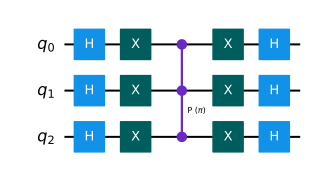

In [7]:
from qiskit import QuantumCircuit
from numpy import pi


def get_diffuser(num_qubits):
    """Creates a diffuser circuit for Grover's algorithm.
    Args:
        num_qubits (int): the number of qubits the diffuser should act on
    Returns:
        QuantumCircuit that implements the diffuser operation
    """
    qc = QuantumCircuit(num_qubits, name="Diffuser")
    qc.h(range(num_qubits))
    qc.x(range(num_qubits))
    qc.mcp(  # multi-controlled-phase gate
        pi,  # rotation angle (equivalent to Z-gate)
        list(range(num_qubits - 1)),  # control qubits
        [num_qubits - 1],  # target qubit
    )
    qc.x(range(num_qubits))
    qc.h(range(num_qubits))
    return qc


get_diffuser(3).draw()

#### The full algorithm

The following code defines a circuit for Grover's algorithm using the oracle and diffuser defined earlier.

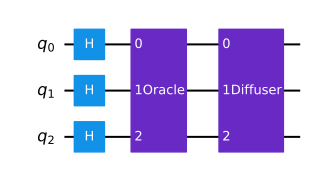

In [8]:
from qiskit import QuantumCircuit

NUM_ITERATIONS = 1

qc = QuantumCircuit(NUM_QUBITS)
qc.h(range(NUM_QUBITS))
for i in range(NUM_ITERATIONS):
    qc.unitary(oracle, range(NUM_QUBITS), label="Oracle")
    qc.append(get_diffuser(NUM_QUBITS), range(NUM_QUBITS))

qc.draw()

The next code cell uses Qiskit's `Statevector` class to simulate the results of running this circuit 1024 times.

In [9]:
from qiskit.quantum_info import Statevector

ket_0 = Statevector.from_label("0" * NUM_QUBITS)
ket_0.evolve(qc).sample_counts(1024)

{'011': 510, '110': 514}

We see roughly a 50-50 chance of measuring `001` and `110`, which are the two "good" bit strings defined in the _Problem form_ section.

## Analysis

For completely unstructured problems (in which we have no information about which states are likely to be good), the best algorithm is _random guessing_. Random guessing chooses random bit strings, and 
Grover's algorithm runs in $O(\sqrt{N_t/N_g})$ time, where $N_t$ is the total number of states to search through, and $N_g$ is the number of good states. The best classical algorithm for completely unstructured search is random guessing, in which we randomly pick states and run the oracle to see if they are good or not. This 

## Performance

- quick proof of runtime
- explain can be improved with domain-specific knowledge

## Links

Grover's algorithm was first published in the following paper.

- Lov K. Grover. 1996. _"A fast quantum mechanical algorithm for database search."_ <https://arxiv.org/abs/quant-ph/9605043>

### Further learning

Check out these links to learn about Grover's algorithm in more detail.

- other explanations


### Later developments

Read later research that builds on Grover's algorithm.

- amplitude amplification
- quantum counting

- N. J. Cerf, L. K. Grover, C. P. Williams. 1998. _"Nested quantum search and NP-complete problems"_ <https://arxiv.org/abs/quant-ph/9806078>

  This paper extends the methods of Grover's algorithm to use some problem structure.

In [5]:
import qiskit.tools.jupyter
%qiskit_version_table